In [1]:
# Імпорт бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score


/Users/alexrovnyak/Documents/r_d_course_ml_forecasting/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


,date,unit_sales
0,2013-01-02,42320.0
1,2013-01-03,32708.0
2,2013-01-04,30847.0
3,2013-01-05,42351.0
4,2013-01-06,43988.0


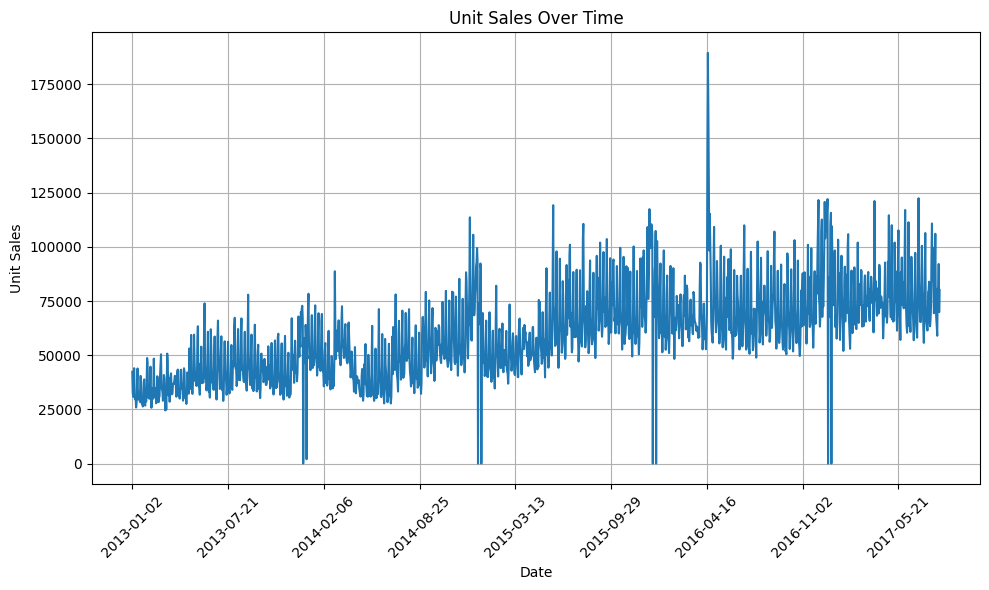

In [2]:
# Зчитування агрегованого датасету
df = pd.read_csv('data.csv')

# Перевірка перших рядків
display(df.head())

# Візуалізація
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['unit_sales'])
plt.title('Unit Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(df['date'][::200], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [3]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('D')

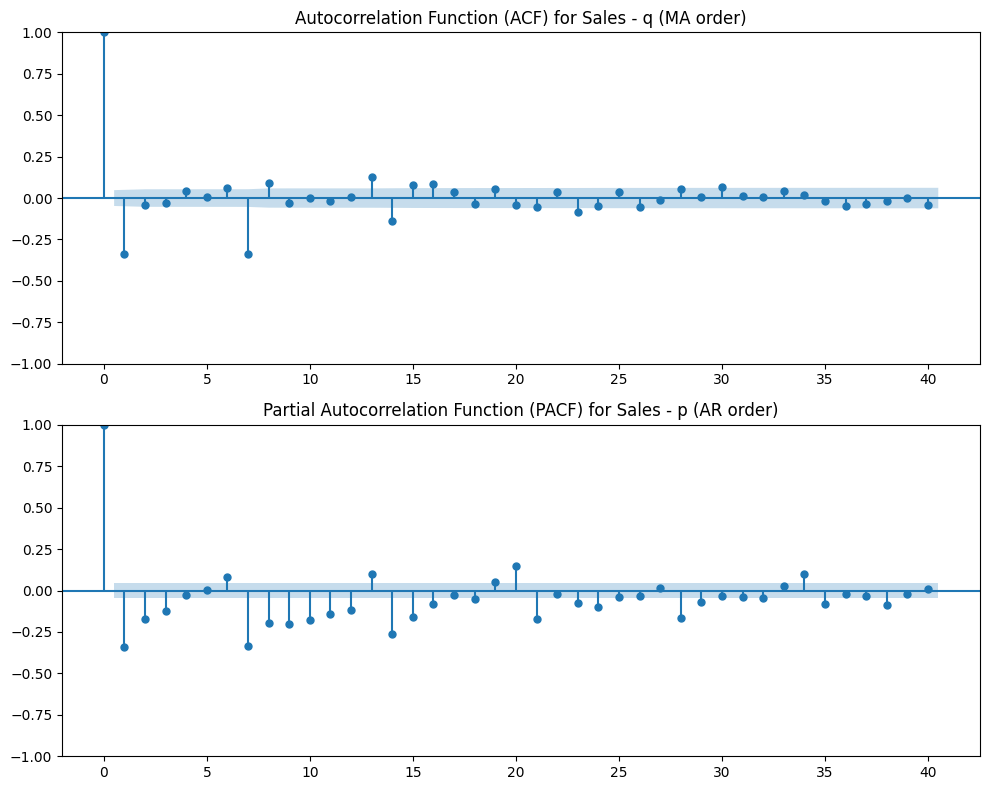

In [4]:
# Make sure the series has no NaNs
unit_sales = df["unit_sales"].dropna()

# first difference (trend)
diff1 = unit_sales.diff()

# seasonal difference with weekly period 7
diff_seasonal = diff1.diff(7)

# drop the leading NaNs from differencing
unit_sales_diffed = diff_seasonal.dropna()

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(unit_sales_diffed, lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) for Sales - q (MA order)') #how people in your life influence you directly + through someone else

plot_pacf(unit_sales_diffed, lags=40, ax=ax[1], method='ywm')
ax[1].set_title('Partial Autocorrelation Function (PACF) for Sales - p (AR order)') #only direct influence, no middlemen

plt.tight_layout()
plt.show()

In [5]:
train, test = df[:-90]['unit_sales'], df[-90:]['unit_sales']


In [6]:
model = ARIMA(train, order=(2,1,1))

model_fit = model.fit()

# Forecast for the next 90 periods using test_exog
forecast = model_fit.forecast(steps=90)

In [7]:
# RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))

# R²
r2 = r2_score(test, forecast)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 15224.38
R²: -0.00


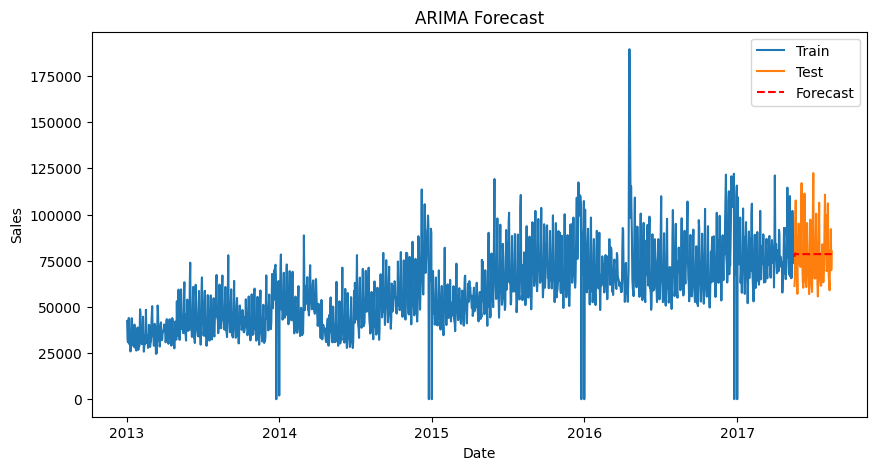

In [8]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', linestyle='--', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [9]:
def make_dow_dummies(index):
    """
    Create 7 dummy columns: dow_0 ... dow_6 based on DatetimeIndex.
    Monday = 0, ..., Sunday = 6
    """
    dow = index.dayofweek
    exog = pd.get_dummies(dow, prefix='dow', drop_first=False)
    exog.index = index
    return exog

# If your target is unit_sales:
# train and test should be Series like:
# train = df_train['unit_sales']; test = df_test['unit_sales']

# ---------- exogenous variables (weekday dummies) ----------
train_exog = make_dow_dummies(train.index)
test_exog = make_dow_dummies(test.index)

In [10]:
model_seasonality = SARIMAX(train,
            order = (2,1,1),
            seasonal_order=(2, 1, 2, 7)
            )
model_seasonality_fit = model_seasonality.fit()

# --- Forecast with seasonal SARIMAX ---
forecast_seasonal = model_seasonality_fit.get_forecast(steps=len(test))
forecast_values_seasonal = forecast_seasonal.predicted_mean
forecast_conf_int_seasonal = forecast_seasonal.conf_int()
print(f"R²: {r2_score(test, forecast_values_seasonal):.4f}")

R²: 0.5851


/Users/alexrovnyak/Documents/r_d_course_ml_forecasting/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


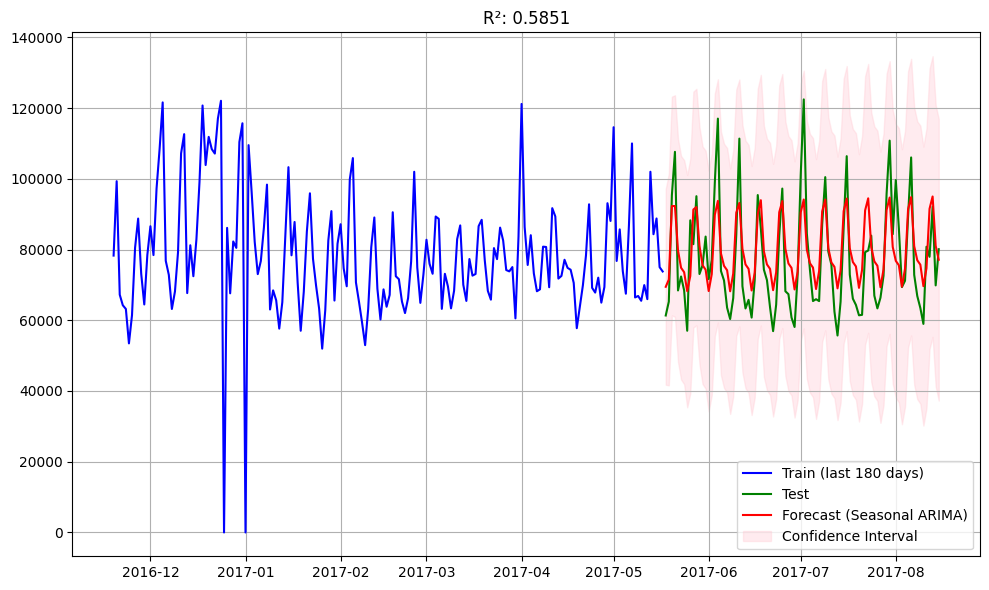

In [11]:
# --- Visualization ---
plt.figure(figsize=(10, 6))
# Plot only the last 180 days of train
plt.plot(train.index[-180:], train.values[-180:], label='Train (last 180 days)', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, forecast_values_seasonal, label='Forecast (Seasonal ARIMA)', color='red')
plt.fill_between(test.index,
                 forecast_conf_int_seasonal.iloc[:, 0],
                 forecast_conf_int_seasonal.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title(f"R²: {r2_score(test, forecast_values_seasonal):.4f}")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [13]:
#to do: show min max of date column

print("Min date in train:", df.index.min())
print("Max date in train:", df.index.max())

Min date in train: 2013-01-02 00:00:00
Max date in train: 2017-08-15 00:00:00
